In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.stattools import adfuller


In [2]:
# Download Reliance stock data
data = yf.download(
    "RELIANCE.NS",
    start="2018-01-01",
    end="2024-01-01"
)

data = data[["Close"]]
data.dropna(inplace=True)

print(data.head())


[*********************100%***********************]  1 of 1 completed

Price            Close
Ticker     RELIANCE.NS
Date                  
2018-01-01  401.864777
2018-01-02  402.483246
2018-01-03  404.095551
2018-01-04  406.525085
2018-01-05  407.828125


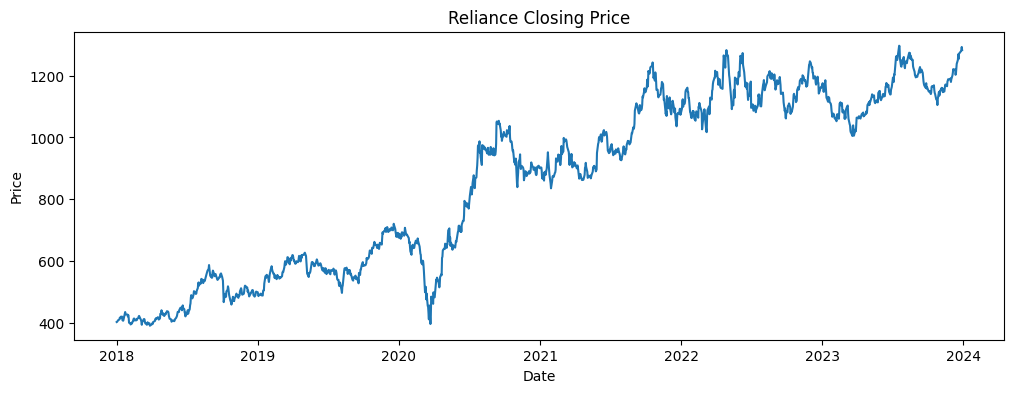

In [3]:
# Plot closing price
plt.figure(figsize=(12,4))
plt.plot(data["Close"])
plt.title("Reliance Closing Price")
plt.xlabel("Date")
plt.ylabel("Price")
plt.show()


In [4]:
# First difference (returns)
data["Returns"] = data["Close"].diff()
data.dropna(inplace=True)


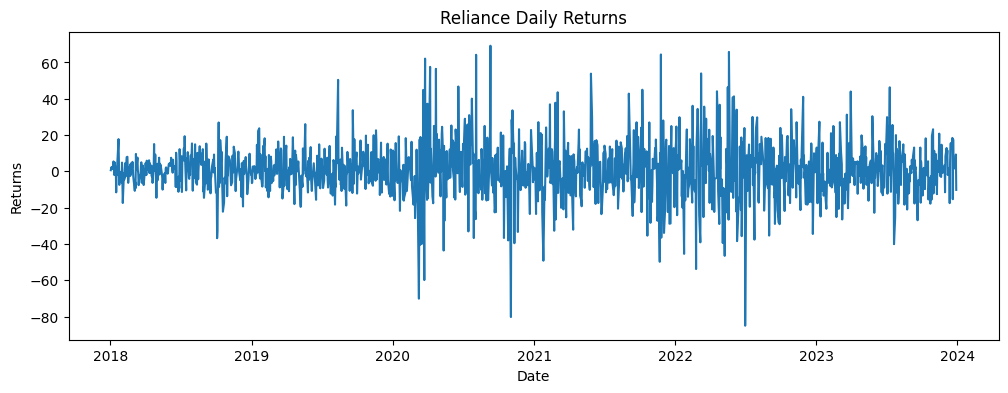

In [5]:
# Plot returns
plt.figure(figsize=(12,4))
plt.plot(data["Returns"])
plt.title("Reliance Daily Returns")
plt.xlabel("Date")
plt.ylabel("Returns")
plt.show()


In [6]:
adf_stat, p_value, *_ = adfuller(data["Returns"])

print("ADF Statistic:", adf_stat)
print("p-value:", p_value)


ADF Statistic: -22.820105940413058
p-value: 0.0


In [7]:
# Train-test split
train_size = int(len(data) * 0.8)

train_returns = data["Returns"][:train_size]
test_returns = data["Returns"][train_size:]

print("Train size:", len(train_returns))
print("Test size:", len(test_returns))


Train size: 1184
Test size: 296


In [8]:
ar_model = AutoReg(train_returns, lags=1).fit()
print(ar_model.summary())


                            AutoReg Model Results                             
Dep. Variable:                Returns   No. Observations:                 1184
Model:                     AutoReg(1)   Log Likelihood               -4905.738
Method:               Conditional MLE   S.D. of innovations             15.301
Date:                Fri, 16 Jan 2026   AIC                           9817.477
Time:                        21:16:58   BIC                           9832.704
Sample:                             1   HQIC                          9823.217
                                 1184                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.5961      0.445      1.339      0.181      -0.276       1.469
Returns.L1     0.0162      0.029      0.557      0.577      -0.041       0.073
                                    Roots           

/home/sachchida/anaconda3/envs/timeseries/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [9]:
future_returns = ar_model.predict(
    start=len(train_returns),
    end=len(train_returns) + 29
)


/home/sachchida/anaconda3/envs/timeseries/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/home/sachchida/anaconda3/envs/timeseries/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/home/sachchida/anaconda3/envs/timeseries/lib/python3.13/site-packages/statsmodels/tsa/deterministic.py:308: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)


In [10]:
last_price = data["Close"].iloc[-1]

future_prices = []
price = last_price

for r in future_returns:
    price = price + r
    future_prices.append(price)

future_prices = pd.Series(
    future_prices,
    index=pd.date_range(
        start=data.index[-1],
        periods=30,
        freq="B"   # business days
    )
)


/home/sachchida/anaconda3/envs/timeseries/lib/python3.13/site-packages/matplotlib/cbook.py:1719: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  return math.isfinite(val)
/home/sachchida/anaconda3/envs/timeseries/lib/python3.13/site-packages/matplotlib/cbook.py:1355: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  return np.asarray(x, float)


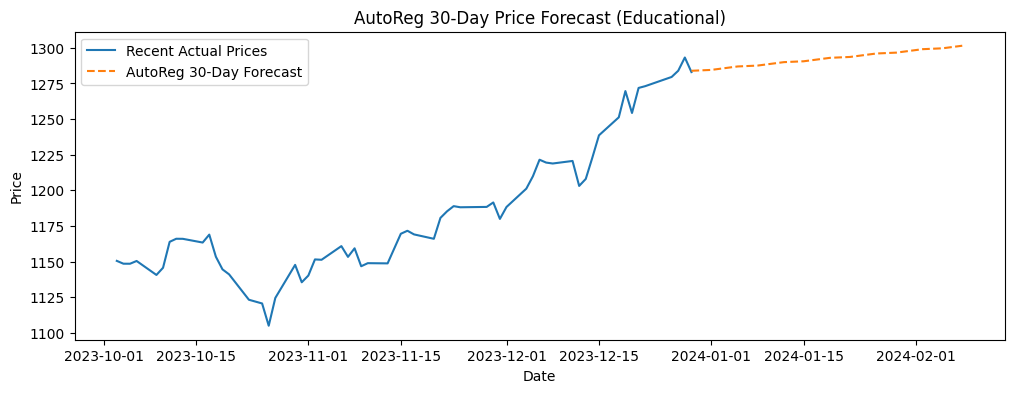

In [11]:
plt.figure(figsize=(12,4))
plt.plot(data["Close"][-60:], label="Recent Actual Prices")
plt.plot(future_prices, label="AutoReg 30-Day Forecast", linestyle="--")
plt.title("AutoReg 30-Day Price Forecast (Educational)")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.show()
